### 构建自己的pipeline 
###### 前向推理，从promt到image

In [1]:
# 导入相关包

import os
import torch
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

In [2]:
#定义相关参数

prompt = ["a photograph of an astronaut riding a horse"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 100           # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
torch.manual_seed(0)                # 看情况是否固定随机种子
batch_size = len(prompt)
device = 'cuda'
save_step = 10


In [3]:
## 一些要用到的函数

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

#多张图片合并 便于可视化
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = transforms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

#这里返回的是图片列表
def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_encode(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0]

In [4]:
#加载模型
#可选fp16版本（torch_dtype=torch.float16）。已经放到gpu上了

tokenizer = CLIPTokenizer.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="vae").to(device)
unet = UNet2DConditionModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="unet").to(device)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(num_inference_steps)

In [5]:
# promt编码成embedding

text_embeddings = text_encode(prompt) 
uncond_embeddings = text_encode([""] * batch_size, text_embeddings.shape[1])
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [6]:
#初始化输入噪声

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8)).to(device)
latents = latents * scheduler.init_noise_sigma #scheduler需要做这一步

/tmp/ipykernel_18579/2178207017.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8)).to(device)


In [7]:
#前向推理流程

for i, t in enumerate(tqdm(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual and perform guidance
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    #保存中间图片
    if (i + 1) % save_step == 0:
        if not os.path.exists(f'./logs'):
            os.mkdir(f'./logs')
        latents_to_pil(latents)[0].save(f'logs/{(i + 1):04}.jpeg')

  0%|          | 0/100 [00:00<?, ?it/s]

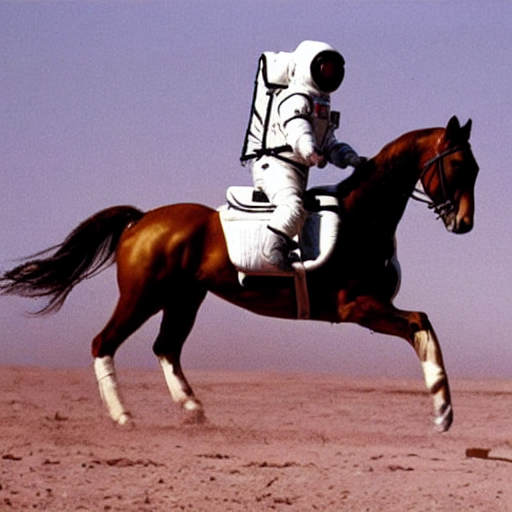

In [8]:
#将latent转化成图片并输出

images = latents_to_pil(latents)
for img in images:display(img)